# Function Approximation

This Notebook demonstrates
1. Defining and using a simple feed-forward NN for function approximation in 1D
1. Using both function and gradient values for calculating the loss
1. Using Torch's Dataset and DataLoader class for batching data

In [34]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from utils import plot

In [35]:
# %matplotlib widget
%matplotlib inline

## Network Definition

In [36]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam,
        use_grad=False,
        act_func=nn.LeakyReLU()):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True),
                nn.LeakyReLU(),
                nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)
            )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        self.use_grad = use_grad
        
    def forward(self, x):
        out = self.layers(x)
        return out

    def loss(self, x, y, y_grad=None):
        out = self.forward(x)
        loss = self.loss_func(y, out)
        if self.use_grad:
            out_grad = torch.autograd.grad(out, x, torch.ones(x.shape), create_graph=True)[0]
            loss += self.loss_func(y_grad, out_grad)
        return loss
    
    def step(self, x, y, y_grad=None):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, y, y_grad)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return loss.detach()

## 1D

### DataLoader

In [37]:
from DatasetFunction1D import DatasetFunction1D
from torch.utils.data import DataLoader

x = torch.linspace(-10,10, 100, requires_grad=True).reshape(-1,1)
dataset = DatasetFunction1D(x)
_, y, y_grad = dataset[:]

dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

N_in = x.shape[1]
N_out = y.shape[1]

### Network Initialisation and training

In [38]:
net = Net(N_in, N_out, N_hid=100)

In [39]:
epochs = 100
train_losses = torch.zeros(epochs)

for i in range(epochs):
    for batch in dataloader:
        x_train, y_train, y_train_grad = batch
        train_losses[i] = net.step(x_train, y_train)

### Evaluation

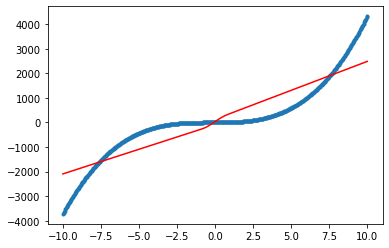

In [40]:
out = net(x)
plot(x, y, '.')
plot(x, out, 'r')
plt.show()

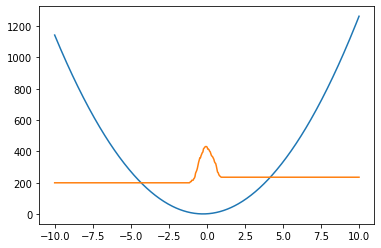

In [41]:
out_grad = torch.autograd.grad(net(x), x, torch.ones(x.shape))[0]

plot(x,y_grad)
plot(x,out_grad)
plt.show()

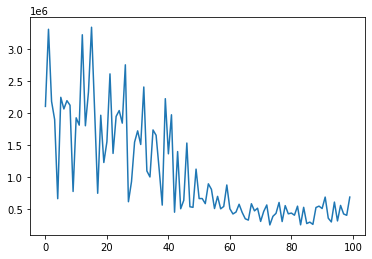

In [42]:
plot(range(epochs), train_losses)